# Sudoku Integer Programming Model
For an $n \times n$ grid let the individual cells be denoted $(i,j)$ where $i$ is the row and $j$ is the column where this cell appears. Let $m = \sqrt{n}$ represent the dimension of the inner boxes of the puzzle. Let $D = \{1,2,...,n\}$ and $E = \{1,2,...,m\}$. Let $C$ denote the $n \times n$ matrix of clues for the puzzle. Its $ij$-th entry, $c_{ij}$, contains either a number that must be in that cell in the solution or a 0 representing a cell that must be filled.
The decision variables are
$$
x_{ijk} = \begin{cases}
    1, & \text{ if cell } (i,j) \text{ contains the integer } k, \text{ for } i,j,k \in D , \\
    0, & \text{ otherwise,}
\end{cases}
$$
and the formulation is
$$
\begin{alignat}{2}
    \text{ minimise } & \textbf{0}^tx \\
    \text{ subject to } & \sum_{i=1}^n x_{ijk} = 1 && \forall j,k \in D \\
    & \sum_{j=1}^n x_{ijk} = 1 && \forall i, k \in D \\
    & \sum_{j = mq - m + 1}^{mq} \ \sum_{i = mp - m + 1}^{mp} x_{ijk} = 1 \quad && \forall k \in D, \ \forall p,q \in E \\
    & \sum_{k = 1}^n x_{ijk} = 1 && \forall i,j \in D \\
    & x_{ijc_{ij}} = 1 && \forall i,j \in D \text{ such that } c_{ij} \neq 0 \\
    & x_{ijk} \in \{0,1\}.
\end{alignat}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import time

In [47]:
def solvesudoku(size, boxsize, clues):
    # Start time
    start = time.time()
    
    # Create model
    model = gp.Model('Sudoku')

    # Suppress output
    model.setParam('OutputFlag', 0)
    
    # Create decision variables
    x_ijk = model.addVars(size, size, size, vtype=GRB.BINARY, name = 'x_ijk')
    
    # Add constraints to account for the given entries of the puzzle
    for i in range(size):
        for j in range(size):
            if clues[i,j] != 0:
                model.addConstr(x_ijk[i,j,clues[i,j]-1] == 1)
    
    # Ensure only one k in each column
    model.addConstrs((x_ijk.sum('*',j,k) == 1 for j in range(size) for k in range(size)), 'c1')
    
    # Ensure only one k in each row
    model.addConstrs((x_ijk.sum(i,'*',k) == 1 for i in range(size) for k in range(size)), 'c2')
    
    # Ensure only one k in each submatrix
    for q in range(boxsize):
        for p in range(boxsize):
            model.addConstrs(gp.quicksum(x_ijk[i,j,k] for i in range(boxsize*p, boxsize*(p+1)) for j in range(boxsize*q, boxsize*(q+1))) == 1 for k in range(size))
    
    # Exactly one k in every cell
    model.addConstrs((x_ijk.sum(i,j,'*') == 1 for i in range(size) for j in range(size)), 'c4')
    
    # Solve the Sudoku puzzle
    model.optimize()
    
    solution = np.zeros((9,9))
    
    # Input the solution into the solution matrix
    for i in range(size):
        for j in range(size):
            for k in range(size):
                if x_ijk[i,j,k].x > 0.5:
                    solution[i,j] = k + 1
    
    # Transform the matrix so that there are no decimals
    solution = solution.astype(int)
    solution = solution.astype(str)

    
    # Extract results
    print("Number of Clues: ", np.count_nonzero(clues))
    end = time.time()
    totaltime = end - start

    print("Time: ", totaltime)
    print("---------------------------------------------------")
    
    return solution              

In [49]:
def display_sudoku(solution):
    size = 9
    boxsize = 3
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xticks(np.arange(0, size+1, 1), minor=True)
    ax.set_yticks(np.arange(0, size+1, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Drawing thick lines for 3x3 box borders and outer border
    for i in range(0, size+1, boxsize):
        ax.axhline(i, color='black', linewidth=3)
        ax.axvline(i, color='black', linewidth=3)
    
    # Drawing outer border
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    
    for i in range(size):
        for j in range(size):
            ax.text(j + 0.5, size - (i + 0.5), str(solution[i, j]), 
                    ha='center', va='center', fontsize=16)
    
    plt.show()


In [51]:
def sudoku_problem(clues):
    size = 9
    boxsize = 3

    # Transform the matrix so that there are no decimals
    clues = clues.astype(int)
    #clues = clues.astype(str)
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xticks(np.arange(0, size+1, 1), minor=True)
    ax.set_yticks(np.arange(0, size+1, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Drawing thick lines for 3x3 box borders and outer border
    for i in range(0, size+1, boxsize):
        ax.axhline(i, color='black', linewidth=3)
        ax.axvline(i, color='black', linewidth=3)
    
    # Drawing outer border
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    
    for i in range(size):
        for j in range(size):
            if clues[i,j] != 0:
                ax.text(j + 0.5, size - (i + 0.5), str(clues[i, j]), 
                        ha='center', va='center', fontsize=16)
    
    plt.show()

In [53]:
# Set up size of the Sudoku matrix
size = 9
boxsize = 3

# Create matrix with given entries
clues = [np.array([[0,0,0,  1,0,7,  0,0,0],
                  [0,0,2,  5,0,3,  4,0,0],
                  [0,1,0,  0,4,0,  0,5,0],
                
                  [5,2,0,  0,7,0,  0,6,9],
                  [0,0,3,  6,0,1,  7,0,0],
                  [6,4,0,  0,8,0,  0,1,5],
                
                  [0,8,0,  0,9,0,  0,2,0],
                  [0,0,5,  4,0,2,  1,0,0],
                  [0,0,0,  8,0,5,  0,0,0]]),
        np.array([[0,0,0,  6,0,0,  0,8,0],
                  [1,0,2,  0,0,0,  5,0,4],
                  [0,5,8,  0,1,0,  0,0,0],
                
                  [0,3,5,  0,7,1,  6,4,9],
                  [6,2,7,  0,9,8,  0,1,5],
                  [4,0,0,  0,6,3,  0,0,0],
                
                  [2,0,0,  0,5,0,  0,0,0],
                  [0,0,0,  7,4,0,  0,5,3],
                  [0,7,0,  1,0,0,  8,0,6]]),
        np.array([[0,0,0,  0,0,0,  6,3,1],
                  [0,0,0,  0,4,0,  0,0,8],
                  [3,1,0,  0,0,6,  0,4,0],
                
                  [5,0,2,  0,0,0,  0,9,4],
                  [0,0,3,  0,0,0,  8,0,2],
                  [0,7,0,  0,0,0,  3,0,6],
                
                  [0,0,0,  9,0,0,  0,2,7],
                  [9,2,4,  6,7,0,  0,8,0],
                  [7,5,8,  0,0,0,  0,6,0]]),
        np.array([[0,0,0,  0,0,0,  0,0,8],
                  [8,0,0,  0,7,0,  4,0,0],
                  [0,0,0,  9,0,8,  7,5,3],
                
                  [0,0,5,  0,6,0,  0,0,0],
                  [1,8,0,  0,0,2,  6,0,0],
                  [0,0,9,  0,1,0,  0,0,0],
                
                  [0,0,0,  1,0,3,  2,4,7],
                  [3,0,0,  0,2,0,  1,0,0],
                  [0,0,0,  0,0,0,  0,0,9]]),
        np.array([[0,8,0,  6,9,1,  0,0,7],
                  [7,0,0,  0,0,0,  0,0,0],
                  [0,9,4,  0,0,2,  0,0,8],
                
                  [0,6,8,  0,0,0,  7,0,3],
                  [0,2,0,  0,0,0,  8,1,0],
                  [4,0,7,  0,0,0,  2,6,0],
                
                  [8,0,0,  5,0,0,  3,7,0],
                  [0,0,0,  0,0,0,  0,0,1],
                  [5,7,0,  3,1,4,  0,0,0]]),
        np.array([[3,0,0,  4,0,0,  9,0,0],
                  [0,0,0,  0,7,0,  0,6,5],
                  [0,9,7,  6,0,0,  0,0,0],
                
                  [0,8,0,  2,3,0,  5,0,0],
                  [0,7,0,  0,0,0,  0,9,0],
                  [0,0,2,  0,9,7,  0,8,0],
                
                  [0,0,0,  0,0,5,  7,3,0],
                  [7,4,0,  0,8,0,  0,5,0],
                  [0,0,5,  0,0,1,  0,0,8]]),
        np.array([[0,0,0,  0,0,0,  0,0,6],
                  [8,6,0,  0,0,0,  0,5,0],
                  [4,0,0,  0,0,2,  0,0,8],
                
                  [0,0,7,  0,0,0,  9,1,0],
                  [0,0,2,  4,0,0,  0,0,0],
                  [0,5,0,  0,0,1,  0,0,0],
                
                  [0,0,0,  6,8,4,  0,0,0],
                  [0,0,0,  0,5,0,  3,0,0],
                  [0,0,0,  0,2,0,  5,0,7]]),
        np.array([[0,0,2,  0,8,5,  0,0,4],
                  [0,0,0,  0,3,0,  0,6,0],
                  [0,0,4,  2,1,0,  0,3,0],
                
                  [0,0,0,  0,0,0,  0,5,2],
                  [0,0,0,  0,0,0,  3,1,0],
                  [9,0,0,  0,0,0,  0,0,0],
                
                  [8,0,0,  0,0,6,  0,0,0],
                  [2,5,0,  4,0,0,  0,0,8],
                  [0,0,0,  0,0,1,  6,0,0]]),
        np.array([[0,0,0,  0,0,0,  0,0,0],
                  [0,0,1,  0,0,2,  0,0,3],
                  [5,0,0,  0,0,7,  0,8,0],
                
                  [8,0,0,  0,0,3,  0,0,7],
                  [0,5,0,  7,0,6,  0,0,1],
                  [4,0,0,  0,0,0,  0,0,6],
                
                  [0,0,0,  4,6,0,  0,0,0],
                  [2,0,0,  0,0,5,  0,9,0],
                  [0,4,0,  0,2,0,  0,3,0]]),
        np.array([[3,0,0,  0,1,4,  0,0,0],
                  [0,0,0,  0,7,0,  0,8,0],
                  [5,0,0,  0,0,0,  6,0,0],
                
                  [0,0,2,  0,0,0,  0,0,0],
                  [0,0,0,  0,0,0,  0,6,3],
                  [0,0,0,  0,2,0,  8,5,9],
                
                  [0,4,0,  0,0,0,  0,0,0],
                  [0,7,5,  0,8,0,  0,0,1],
                  [1,0,0,  9,0,3,  0,0,0]])]

for i in range(10):
    solvesudoku(size, boxsize, clues[i])

Number of Clues:  32
Time:  0.030795574188232422
---------------------------------------------------
Number of Clues:  36
Time:  0.02434706687927246
---------------------------------------------------
Number of Clues:  32
Time:  0.023172616958618164
---------------------------------------------------
Number of Clues:  26
Time:  0.015624523162841797
---------------------------------------------------
Number of Clues:  31
Time:  0.015623331069946289
---------------------------------------------------
Number of Clues:  29
Time:  0.016095638275146484
---------------------------------------------------
Number of Clues:  22
Time:  0.031687021255493164
---------------------------------------------------
Number of Clues:  23
Time:  0.01564502716064453
---------------------------------------------------
Number of Clues:  23
Time:  0.01562666893005371
---------------------------------------------------
Number of Clues:  22
Time:  0.03125405311584473
----------------------------------------------

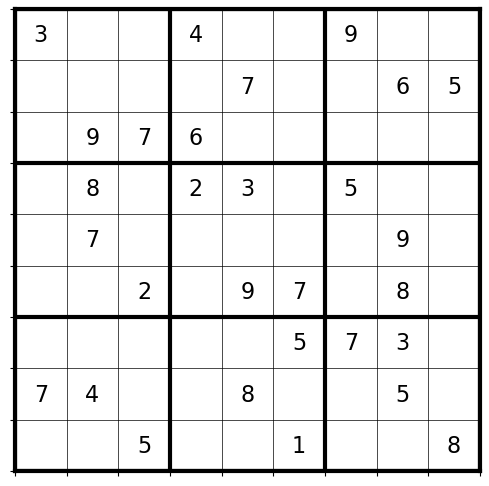

Number of Clues:  29
Time:  0.031649112701416016
---------------------------------------------------


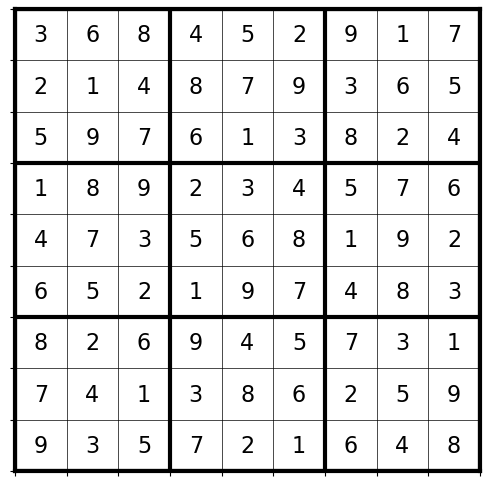

In [55]:
sudoku_problem(clues[5])

solution = solvesudoku(size, boxsize, clues[5])
display_sudoku(solution)